# Searching for specific features
-----
Dec 2016.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from datetime import datetime
from labm8.py import fs
from labm8.py import viz

import clgen
from clgen import corpus

plt.style.use(["seaborn-white", "seaborn-paper"])

## Experimental Methodology

Experimental platforms: cc[123]. NVIDIA GTX 1080.

Search algorithm:

```py
def search(model, target_code):
    code = model.get_good_sample()
    distance = feature_distance(code, target_code)
    best_code = code
    for range(1, 1000):
        new_code = ''
        for range(1, 500):
            seed_state = randint()
            seed_idx = randint() % (len(code) - len('__kernel void '))
            seed_text = code[:seed_idx]
            s = model.sample(seed_text, seed_state)
            if is_good_sample(s):
                new_code = s
                break
                
        if new_code == '':
            code = code_history[-1]  # step back
        else:
            code = new_code
            new_distance = feature_distance(new_code, target_code)
            if new_distance < distance:
                distance = new_distance
                best_code = code
```

## 2. Experimental results

In [2]:
logs = [
    'search/search-A-1.log',
    'search/search-A-2.log',
    'search/search-A-3.log',
    'search/search-A-4.log',
    'search/search-A-5.log',
    'search/search-A-6.log',
]

## 3. Evaluation

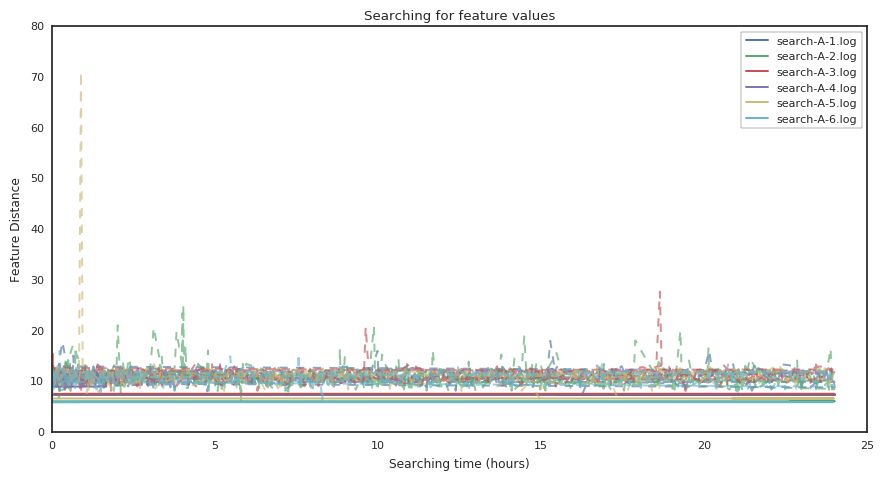

In [3]:
for log in logs:
    data = clgen.load_json_file(log)
    start_time = datetime.strptime(data[0]['date'], '%Y-%m-%d %H:%M:%S')
    dates = [0]
    bests = [data[0]['data']['distance']]
    distances = [data[0]['data']['distance']]
    for entry in data:
        if entry.get("name") == "step" and not entry['data'].get("step_back"):
            timestamp = datetime.strptime(entry['date'], '%Y-%m-%d %H:%M:%S') 
            time = (timestamp - start_time).seconds / 60 / 60
            dates.append(time)
            bests.append(entry['data']['best']['distance'])
            distances.append(entry['data']['distance'])
    
    line, = plt.plot(dates, bests, label=fs.basename(log))
    plt.plot(dates, distances, alpha=.65, color=line.get_color(), linestyle='--')

ax = plt.gca()
plt.legend(loc='upper right')
ax.get_legend().set_title("")
ax.get_legend().draw_frame(True)

plt.title("Searching for feature values")
plt.xlabel("Searching time (hours)")
plt.ylabel("Feature Distance")
viz.finalise(figsize=(9, 5))

In [8]:
for log in logs:
    data = clgen.load_json_file(log)
    i = 0
    start_code = data[0]['data']["start_code"]
    start_distance = data[0]['data']["distance"]
    try:
        best_distance = data[-1]['data']['best']['distance']
        best_code = data[-1]['data']['best']['code']
    except KeyError:
        best_distance = data[-1]['data']['best_distance']
        best_code = data[-1]['data']['best_code']
        
    diff = 1 - (best_distance / start_distance)
    print("//", log, "INIT distance: {:.2f}".format(start_distance))
    print(start_code)
    print("//", log, "BEST distance: {:.2f} ({:.2f}%)".format(best_distance, -diff * 100))
    print(best_code)
    print()

// search/search-A-1.log INIT distance: 11.03
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < d)
    b[e] = b[e];
}
// search/search-A-1.log BEST distance: 7.35 (-33.34%)
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < d)
    b[e] = d * c[2 * e + 0];
  else if (e < 8)
    c[e] = a[e] + c[e + 3];
}

// search/search-A-2.log INIT distance: 9.54
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e >= d)
    return;

  int f = e << 2;
  c[e] = a[f] + b[f];
}
// search/search-A-2.log BEST distance: 6.10 (-36.05%)
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e >= d)
    return;

  for (int f = 0; f < d; f++) {
    if (e + d % 4 + f < 2 && e < d)
      b[e] += b[e - 4];
  }
  if (e > c)
   